# Sentiment Analysis on The Reddit Climate Change Dataset
by *Santiago Segovia*

Lines of code: ~ 400

### Motivation

We will use the Reddit Climate Change Dataset to fine-tune a DistilBERT model that is able to classify whether a comment in Reddit towards climate change is positive or negative. The analysis follows [this publication](https://huggingface.co/blog/sentiment-analysis-python) from Hugginface.

The first pre-trained model we use is `distilbert-base-uncased`. We'll use this results as a baseline

### 1. Install Dependencies and Initial Setup

In [ ]:
!pip install datasets transformers accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from google.colab import drive
from transformers import pipeline
from transformers import TrainingArguments, Trainer

In [ ]:
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    train_obs = 15000
    test_obs = 1500
    print("Using cuda.")
else:
    DEVICE = torch.device('cpu')
    train_obs = 3000
    test_obs = 300
    print("Using cpu.")

Using cpu.


In [ ]:
# Mount GDrive
drive.mount("/content/drive")

# Define data path and size of data boolean
data_path = "/content/drive/Shareddrives/adv-ml-project/Data/"
small_data = True

Mounted at /content/drive


In [ ]:
# Load data (takes ~1 min to load)
dtype_dict = {'label': int}
comments = pd.read_csv(data_path + "by_threshold/comments_filtered.csv", quoting=csv.QUOTE_NONNUMERIC, dtype=dtype_dict)

### 2. Preprocess Data

In order to evaluate the performance of our model, we need to create a train-test split. We randomly pick 20% of the records and identify them as part of the testing dataset. We also need to convert our data to an iterable dataset to easily use Hugginface's functions. We use the `from_dict()` method from the `datasets` [module](https://huggingface.co/docs/datasets/en/create_dataset).

In [ ]:
import random
from datasets import Dataset

random.seed(120938)

def train_test_split(df, share_test_obs):
  # Identify the observations to assign as test
  num_test_obs = round(df.shape[0] * share_test_obs)
  ids_test_obs = random.sample(range(df.shape[0]), num_test_obs)
  df['test_split'] = 0
  df.loc[ids_test_obs,'test_split'] = 1

  # Fill NaN values with empty strings, otherwise from_dict will raise an error
  df['body'] = df['body'].fillna('')

  # Creates Dataset from dictionary
  train_dict = {"text": df.loc[df['test_split'] == 0, 'body'].tolist(),
                "label": df.loc[df['test_split'] == 0, 'label'].tolist()}
  test_dict = {"text": df.loc[df['test_split'] == 1, 'body'].tolist(),
               "label": df.loc[df['test_split'] == 1, 'label'].tolist()}
  train_df = Dataset.from_dict(train_dict)
  test_df = Dataset.from_dict(test_dict)

  return train_df, test_df

In [ ]:
# Create train and test data
train_data, test_data = train_test_split(comments, 0.2)

In [ ]:
# Create a smaller training dataset for faster training times
small_train_dataset = train_data.shuffle(seed=42).select([i for i in list(range(train_obs))])
small_test_dataset = test_data.shuffle(seed=42).select([i for i in list(range(test_obs))])

In [ ]:
# Example of structures
print(small_train_dataset[0])
print(small_test_dataset[0])

{'text': "&gt;prove how the Democratic Party establishment is a nightmare.\n\n* No action on climate change.\n* No action on wealth inequality\n* Failed health insurance legislation\n* Lost to Trump\n* Lost 1000 elected positions in 10 years\n* Supported Bush's illegal Iraq war\n* Support obscenely bloated defense budget\n* Interfere in primary elections\n* Don't represent their constituents, only represent billionaires\n* Love them some Wall Street\n* The list is endless", 'label': 0}
{'text': "I've also noticed our weather patterns change. Used to be that what happened in Vancouver was happening 100km inland, north and south. Now there are small weather pockets all the time. I've driven through Metro Vancouver and gone through hail, rain, snow, and warm sun in less than 20 minutes. Never happened as a kid.\n\nTo me, those types of changes, especially when it's every year and all the time, are great examples of how weather's affected by and a symptom of climate change.", 'label': 1}


<ipython-input-10-a176510eb35a>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.barplot(x='Label', y='Count', data=label_df).set_xticklabels(['Negative','Positive'])


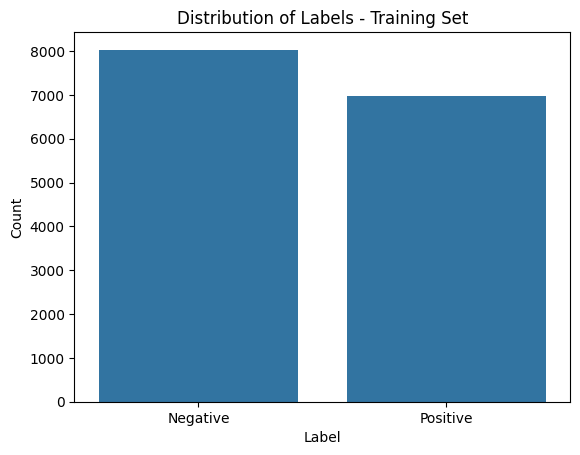

In [ ]:
from collections import Counter

# Count the number of observations by class
label_counts = Counter(small_train_dataset['label'])

# Convert the counts to a DataFrame for easy plotting
label_df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])

# Plotting
sns.barplot(x='Label', y='Count', data=label_df).set_xticklabels(['Negative','Positive'])
plt.title('Distribution of Labels - Training Set')
plt.show()

<ipython-input-11-91f584b218a9>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  sns.barplot(x='Label', y='Count', data=label_df).set_xticklabels(['Negative','Positive'])


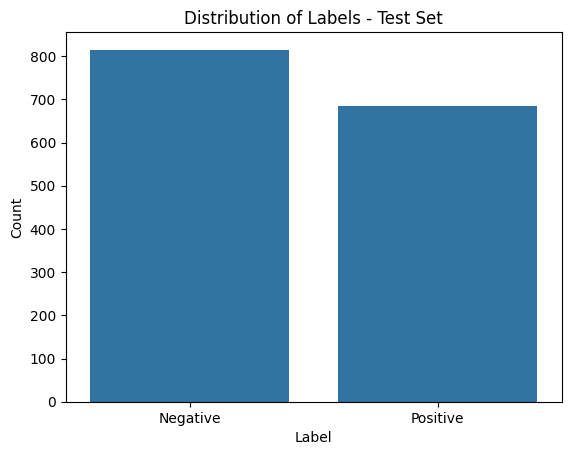

In [ ]:
# Count the number of observations by class
label_counts = Counter(small_test_dataset['label'])

# Convert the counts to a DataFrame for easy plotting
label_df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])

# Plotting
sns.barplot(x='Label', y='Count', data=label_df).set_xticklabels(['Negative','Positive'])
plt.title('Distribution of Labels - Test Set')
plt.show()

To [preprocess](https://huggingface.co/docs/transformers/preprocessing#everything-you-always-wanted-to-know-about-padding-and-truncation) our data, we will use [DistilBERT tokenizer](https://huggingface.co/docs/transformers/v4.15.0/en/model_doc/distilbert#transformers.DistilBertTokenizer):


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Next, we prepare the text inputs for the model for both splits of our dataset (training and test) by using the [map method](https://huggingface.co/docs/datasets/en/process#map) with [batch processing](https://huggingface.co/docs/datasets/en/process#batch-processing):

In [ ]:
# Prepare the text inputs for the model
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
if small_data:
    tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
    tokenized_test = small_test_dataset.map(preprocess_function, batched=True)
else:
    tokenized_train = train_data.map(preprocess_function, batched=True)
    tokenized_test = test_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Sentences aren’t always the same length which can be an issue because the model inputs need to have a uniform shape. Padding is a strategy for ensuring tensors are rectangular by adding a special padding token to shorter sentences. We use a [Data Collator](https://huggingface.co/docs/transformers/en/main_classes/data_collator) to convert our training samples to PyTorch tensors and concatenate them with the correct amount of [padding](https://huggingface.co/docs/transformers/preprocessing#pad):

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
data_collator

DataCollatorWithPadding(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

### 3. Training the model

For training, we will be using the [Trainer API](https://huggingface.co/docs/transformers/v4.15.0/en/main_classes/trainer#transformers.Trainer), which is optimized for fine-tuning Transformers models such as DistilBERT.

First, we define DistilBERT as our base model:

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Then, we define the metrics we'll be using to evaluate how good is the fine-tuned model ([accuracy and f1 score](https://huggingface.co/metrics)):

In [ ]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

Before training our model, we need to define the training arguments and define a Trainer with all the objects we constructed up to this point:

In [ ]:
output_name = data_path + "Output/general"

training_args = TrainingArguments(
   output_dir=output_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

Now, we train the model on the dataset:

In [ ]:
trainer.train()

Step,Training Loss
500,0.518000
1000,0.380000
1500,0.277300
2000,0.243000
2500,0.185500


TrainOutput(global_step=2814, training_loss=0.3042374687493059, metrics={'train_runtime': 1683.4363, 'train_samples_per_second': 26.731, 'train_steps_per_second': 1.672, 'total_flos': 4913834687279136.0, 'train_loss': 0.3042374687493059, 'epoch': 3.0})

Finally, we compute the evaluation metrics to see how good your model is:

In [ ]:
trainer.evaluate()

<ipython-input-18-dcbaed1ca091>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.46202319860458374,
 'eval_accuracy': 0.862,
 'eval_f1': 0.8454070201643018,
 'eval_runtime': 21.858,
 'eval_samples_per_second': 68.625,
 'eval_steps_per_second': 4.3,
 'epoch': 3.0}

### 4. Training Over Different SubReddits

In this section we'll train five additional models based on a subset of subreddits. We will then test how those models perform on the original test data. The reason behind this is that different subreddits have different sentiment, so we are interesting in seeing how biased the model is once it is trained on more positive/negative data

#### 4.1 Data Subset

We'll begin by plotting the average sentiment for each of our categories:

In [ ]:
sub_comments = pd.read_csv(data_path + "by_category/comments_filtered.csv", quoting=csv.QUOTE_NONNUMERIC, dtype=dtype_dict)

In [ ]:
# Define date
sub_comments['date'] = pd.to_datetime(sub_comments['date'])
sub_comments['year'] = sub_comments['date'].dt.to_period('Y').dt.to_timestamp()
sub_comments['year_month'] = sub_comments['date'].dt.to_period('M').dt.to_timestamp()

In [ ]:
# Sentiment by category and year-month
avg_sentiment_cat = sub_comments.groupby(['subreddit.name','year_month']).agg({'sentiment':'mean'}).reset_index().rename(columns={'sentiment':'avg_sentiment'})

In [ ]:
def plot_facets(df, categories):

    # Calculate global min and max sentiment scores for consistent y-axis limits
    global_min = df['avg_sentiment'].min()
    global_max = df['avg_sentiment'].max()

    # Create the FacetGrid
    g = sns.FacetGrid(df, col='subreddit.name', col_wrap=3, height=4, sharey=False)

    # Map the lineplot
    g.map_dataframe(sns.lineplot, 'year_month', 'avg_sentiment')

    # Set the same y-axis limits for all plots
    g.set(ylim=(global_min, global_max))

    # Set the titles and labels
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Year", "Average Sentiment")

    # Rotate x-axis labels and adjust layout
    for ax in g.axes.flatten():
        ax.tick_params(labelbottom=True)
        plt.setp(ax.get_xticklabels(), rotation=45)

    plt.tight_layout()  # Adjust layout to fit all elements
    plt.show()

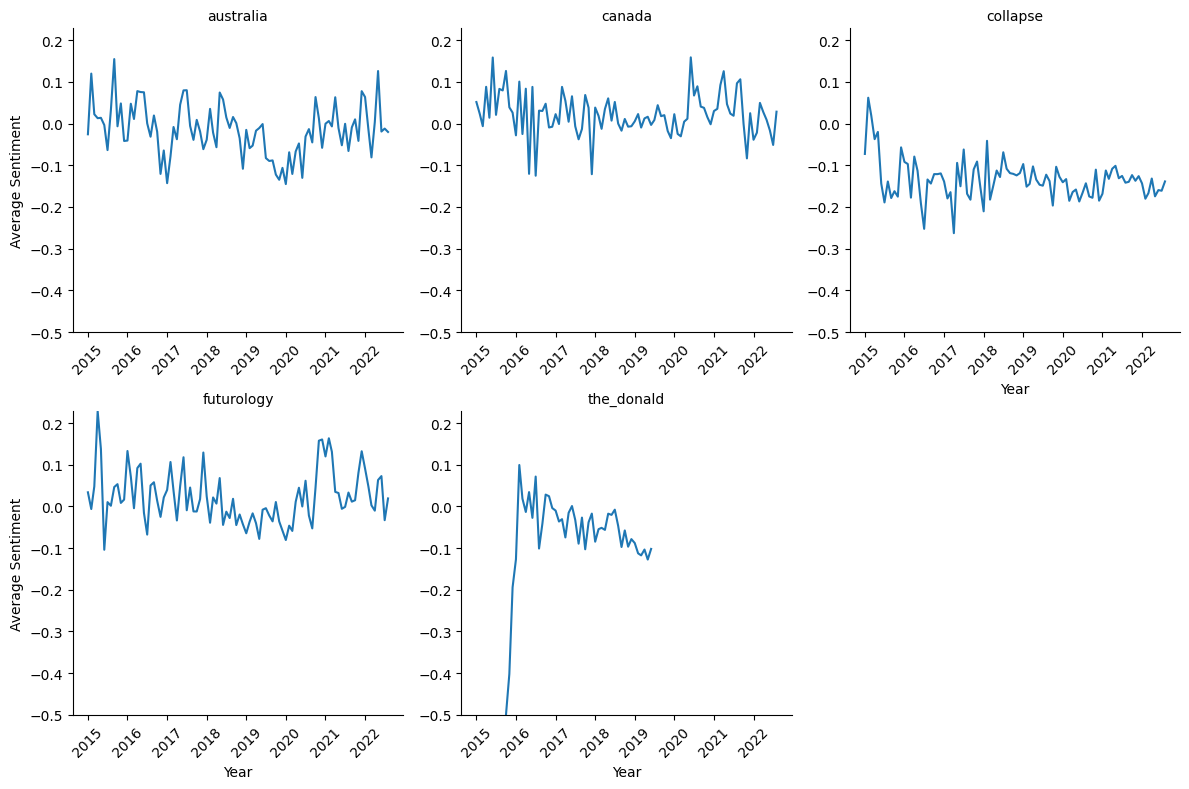

In [ ]:
plot_facets(avg_sentiment_cat, avg_sentiment_cat['subreddit.name'].unique())

As we can see from the previous plot, the average sentiment of three out of five categories is somewhat positive, while the others are more negative. The `the_donald` subreddit is and interesting [case study](https://en.wikipedia.org/wiki/R/The_Donald), as it was closed in June 2020 due to violation of harassment policies from Reddit.

#### 4.2 Pre-processing

We conduct the same steps as before for the pre-processing part for each one of the datasets:

In [ ]:
# Subset data by subreddit
australia_comments = sub_comments[sub_comments['subreddit.name']=='australia'].reset_index(drop=True)
canada_comments = sub_comments[sub_comments['subreddit.name']=='canada'].reset_index(drop=True)
collapse_comments = sub_comments[sub_comments['subreddit.name']=='collapse'].reset_index(drop=True)
futurology_comments = sub_comments[sub_comments['subreddit.name']=='futurology'].reset_index(drop=True)
donald_comments = sub_comments[sub_comments['subreddit.name']=='the_donald'].reset_index(drop=True)

In [ ]:
# Obtain train split for each dataset
australia_train, _ = train_test_split(australia_comments, 0.2)
canada_train, _ = train_test_split(canada_comments, 0.2)
collapse_train, _ = train_test_split(collapse_comments, 0.2)
futurology_train, _ = train_test_split(futurology_comments, 0.2)
donald_train, _ = train_test_split(donald_comments, 0.2)

In [ ]:
# Create a smaller training dataset for faster training times
small_australia_train = australia_train.shuffle(seed=42).select([i for i in list(range(train_obs))])
small_canada_train = canada_train.shuffle(seed=42).select([i for i in list(range(train_obs))])
small_collapse_train = collapse_train.shuffle(seed=42).select([i for i in list(range(train_obs))])
small_futurology_train = futurology_train.shuffle(seed=42).select([i for i in list(range(train_obs))])
small_donald_train = donald_train.shuffle(seed=42).select([i for i in list(range(train_obs))])

In [ ]:
# Tokenize train data
australia_tokenized = small_australia_train.map(preprocess_function, batched=True)
canada_tokenized = small_canada_train.map(preprocess_function, batched=True)
collapse_tokenized = small_collapse_train.map(preprocess_function, batched=True)
futurology_tokenized = small_futurology_train.map(preprocess_function, batched=True)
donald_tokenized = small_donald_train.map(preprocess_function, batched=True)

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

#### 4.3 Testing the models

##### a. `australia` subreddit:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_name = data_path + "Output/australia"

training_args = TrainingArguments(
   output_dir=output_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch",
)

australia_trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=australia_tokenized,
   eval_dataset=tokenized_test, # Leave the original one
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
australia_trainer.train()

Step,Training Loss
500,0.527100
1000,0.401000
1500,0.280600
2000,0.244800
2500,0.182400


TrainOutput(global_step=2814, training_loss=0.3102762416142814, metrics={'train_runtime': 1690.5513, 'train_samples_per_second': 26.619, 'train_steps_per_second': 1.665, 'total_flos': 4800455012848224.0, 'train_loss': 0.3102762416142814, 'epoch': 3.0})

In [ ]:
australia_trainer.evaluate()

<ipython-input-13-dcbaed1ca091>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.4679052233695984,
 'eval_accuracy': 0.856,
 'eval_f1': 0.8353658536585367,
 'eval_runtime': 23.0189,
 'eval_samples_per_second': 65.164,
 'eval_steps_per_second': 4.084,
 'epoch': 3.0}

##### b. `canada` subreddit:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_name = data_path + "Output/canada"

training_args = TrainingArguments(
   output_dir=output_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch",
)

canada_trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=canada_tokenized,
   eval_dataset=tokenized_test, # Leave the original one
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
canada_trainer.train()

Step,Training Loss
500,0.532300
1000,0.405600
1500,0.300800
2000,0.260800
2500,0.199400


TrainOutput(global_step=2814, training_loss=0.3239961948137209, metrics={'train_runtime': 1716.5367, 'train_samples_per_second': 26.216, 'train_steps_per_second': 1.639, 'total_flos': 4973769975761664.0, 'train_loss': 0.3239961948137209, 'epoch': 3.0})

In [ ]:
canada_trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next majo

{'eval_loss': 0.4373559057712555,
 'eval_accuracy': 0.8553333333333333,
 'eval_f1': 0.8391401037805782,
 'eval_runtime': 21.3792,
 'eval_samples_per_second': 70.162,
 'eval_steps_per_second': 4.397,
 'epoch': 3.0}

##### c. `collapse` subreddit:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_name = data_path + "Output/collapse"

training_args = TrainingArguments(
   output_dir=output_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch",
)

collapse_trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=collapse_tokenized,
   eval_dataset=tokenized_test, # Leave the original one
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
collapse_trainer.train()

Step,Training Loss
500,0.517300
1000,0.398400
1500,0.296300
2000,0.261600
2500,0.197400


Step,Training Loss
500,0.517300
1000,0.398400
1500,0.296300
2000,0.261600
2500,0.197400


TrainOutput(global_step=2814, training_loss=0.3190629941483466, metrics={'train_runtime': 1987.1715, 'train_samples_per_second': 22.645, 'train_steps_per_second': 1.416, 'total_flos': 5475722066118912.0, 'train_loss': 0.3190629941483466, 'epoch': 3.0})

In [ ]:
collapse_trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next majo

{'eval_loss': 0.4619864225387573,
 'eval_accuracy': 0.8453333333333334,
 'eval_f1': 0.8250377073906486,
 'eval_runtime': 23.2105,
 'eval_samples_per_second': 64.626,
 'eval_steps_per_second': 4.05,
 'epoch': 3.0}

##### d. `futurology` subreddit:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_name = data_path + "Output/futurology"

training_args = TrainingArguments(
   output_dir=output_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch",
)

futurology_trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=futurology_tokenized,
   eval_dataset=tokenized_test, # Leave the original one
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
futurology_trainer.train()

Step,Training Loss
500,0.528800
1000,0.403100
1500,0.296900
2000,0.255400
2500,0.194100


TrainOutput(global_step=2814, training_loss=0.318199163137299, metrics={'train_runtime': 1821.1602, 'train_samples_per_second': 24.71, 'train_steps_per_second': 1.545, 'total_flos': 5134989009335328.0, 'train_loss': 0.318199163137299, 'epoch': 3.0})

In [ ]:
futurology_trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next majo

{'eval_loss': 0.48372915387153625,
 'eval_accuracy': 0.8373333333333334,
 'eval_f1': 0.8154311649016642,
 'eval_runtime': 23.2342,
 'eval_samples_per_second': 64.56,
 'eval_steps_per_second': 4.046,
 'epoch': 3.0}

##### e. `the_donald` subreddit:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_name = data_path + "Output/the_donald"

training_args = TrainingArguments(
   output_dir=output_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch",
)

donald_trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=donald_tokenized,
   eval_dataset=tokenized_test, # Leave the original one
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
donald_trainer.train()

Step,Training Loss
500,0.511300
1000,0.395600
1500,0.280400
2000,0.248900
2500,0.179200


TrainOutput(global_step=2814, training_loss=0.3059820732328175, metrics={'train_runtime': 1637.7124, 'train_samples_per_second': 27.477, 'train_steps_per_second': 1.718, 'total_flos': 4760042107242624.0, 'train_loss': 0.3059820732328175, 'epoch': 3.0})

In [ ]:
donald_trainer.evaluate()

<ipython-input-11-dcbaed1ca091>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.5102483034133911,
 'eval_accuracy': 0.8453333333333334,
 'eval_f1': 0.8226299694189603,
 'eval_runtime': 23.2074,
 'eval_samples_per_second': 64.634,
 'eval_steps_per_second': 4.05,
 'epoch': 3.0}

### 5. Testing the Models on Different Climate Sentences

The purpose of training different models on different subreddits is to analyze how the sentiment of the same sentences changes. This could indicate if there is a particular bias depending on the data the model is trained on.

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

# Specify the path where the models are stored (last checkpoints)
subreddits = ['general', 'australia', 'canada', 'collapse', 'futurology', 'the_donald']
checkpoint_paths = [data_path + 'Output/' + sub + '/checkpoint-2814' for sub in subreddits]

def model_pipeline(path):
  # Load the tokenizer and model from the checkpoint
  tokenizer = AutoTokenizer.from_pretrained(path)
  model = AutoModelForSequenceClassification.from_pretrained(path)

  # Create a pipeline for sentiment analysis
  sentiment_pipeline = pipeline("sentiment-analysis",
                                model=model,
                                tokenizer=tokenizer)

  return sentiment_pipeline

In [ ]:
pipelines = [model_pipeline(path) for path in checkpoint_paths]

We begin by using a sentence that's nuanced enough to elicit varied interpretations based on the differing perspectives and sentiments prevalent in each subreddit community. An example of this provided by ChatGPT is the following:

In [ ]:
sentence = "Despite the alarming rate of glacier melt observed globally, there remains \
  significant debate around the allocation of funding and resources for climate change \
  mitigation efforts. What are your thoughts on prioritizing economic growth over \
  environmental preservation in the short term?"

# Predict the sentiment
for pipe, model in zip(pipelines, subreddits):
  sentiment = pipe(sentence)
  tag = sentiment[0]['label']
  score = sentiment[0]['score']
  if tag == 'LABEL_0':
    print(f"The sentiment using the {model} model is negative with a score of {score}")
  else:
    print(f"The sentiment using the {model} model is positive with a score of {score}")

The sentiment using the general model is positive with a score of 0.992649495601654
The sentiment using the australia model is positive with a score of 0.9954534769058228
The sentiment using the canada model is positive with a score of 0.9938634634017944
The sentiment using the collapse model is positive with a score of 0.9927675724029541
The sentiment using the futurology model is positive with a score of 0.9918828010559082
The sentiment using the the_donald model is positive with a score of 0.9823577404022217


In this case, the different models consistently classified the sentiment as positive with similar scores.

An interesting way to test our models ability to understand nuanced sentiment is by using a sentence that mixes positive adjectives used in a negative context:

In [ ]:
sentence = "The astonishing refusal by Donald Trump to acknowledge the realities of climate \
change alarmingly exacerbates the challenge of mobilizing global action towards sustainability. \
How can we effectively bridge the gap that such remarkable skepticism creates in our fight against \
environmental degradation?"

# Predict the sentiment
for pipe, model in zip(pipelines, subreddits):
  sentiment = pipe(sentence)
  tag = sentiment[0]['label']
  score = sentiment[0]['score']
  if tag == 'LABEL_0':
    print(f"The sentiment using the {model} model is negative with a score of {score}")
  else:
    print(f"The sentiment using the {model} model is positive with a score of {score}")

The sentiment using the general model is negative with a score of 0.6175808906555176
The sentiment using the australia model is negative with a score of 0.9471485018730164
The sentiment using the canada model is negative with a score of 0.7783833742141724
The sentiment using the collapse model is negative with a score of 0.689780056476593
The sentiment using the futurology model is negative with a score of 0.9667160511016846
The sentiment using the the_donald model is positive with a score of 0.9376218318939209


As we can see from this example, five out of six models classified the sentence as negative, although the scores were not as high as in the previous examples. More interestangly, the only model that classified the sentence as positive with a high score was the one trained on data from the `the_donald` subrredit. This showcases the importance of the data we use to pre-train our models to account for biases.